In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed
from tqdm import tqdm
from prophet.diagnostics import performance_metrics
from itertools import product
from prophet import Prophet

In [2]:
df = pd.read_csv('DF_FINAL.csv')
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])
df

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
0,A,a,AC,TP 0.2,2023-01-06,1.000000,0.010000,A_a_AC_TP 0.2
1,A,a,AC,TP 0.2,2023-01-13,1.000000,4.010000,A_a_AC_TP 0.2
2,A,a,AC,TP 0.2,2023-01-20,61.000000,6.010000,A_a_AC_TP 0.2
3,A,a,AC,TP 0.2,2023-01-27,0.000000,8.010000,A_a_AC_TP 0.2
4,A,a,AC,TP 0.2,2023-02-03,18.879000,9.520000,A_a_AC_TP 0.2
...,...,...,...,...,...,...,...,...
58305,I,an,AD,PET 1.0,2024-11-29,54.766687,78.192999,I_an_AD_PET 1.0
58306,I,an,AD,PET 1.0,2024-12-06,65.133425,171.193998,I_an_AD_PET 1.0
58307,I,an,AD,PET 1.0,2024-12-13,59.458602,46.503001,I_an_AD_PET 1.0
58308,I,an,AD,PET 1.0,2024-12-20,77.697035,8.463000,I_an_AD_PET 1.0


In [10]:
# Метрики
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.where(denom == 0, 1, denom)) * 100

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

In [4]:
# Фильтрация одного временного ряда
target_row = 'A_a_AD_PET 1.0'
df_row = df[df["row_id"] == target_row].copy()

# Приводим к формату, подходящему для prophet
df_row = df_row.rename(columns={"Week_End_Date": "ds", "fact": "y"})

# Сортировка на всякий случай
df_row = df_row.sort_values("ds").reset_index(drop=True)

# Быстрый sanity check
df_row.head()

,Territory_code,Plant_code,Brand_code,Package,ds,Sum of Plan,y,row_id
0,A,a,AD,PET 1.0,2023-01-06,254.000000,188.010000,A_a_AD_PET 1.0
1,A,a,AD,PET 1.0,2023-01-13,265.000000,266.010000,A_a_AD_PET 1.0
2,A,a,AD,PET 1.0,2023-01-20,1923.000000,557.010000,A_a_AD_PET 1.0
3,A,a,AD,PET 1.0,2023-01-27,1137.000000,1505.010000,A_a_AD_PET 1.0
4,A,a,AD,PET 1.0,2023-02-03,129.066998,357.155996,A_a_AD_PET 1.0


In [5]:
# Расчёт индексов для разбиения
n = len(df_row)
train_size = int(n * 0.90)
val_size = int(n * 0.05)

train_df = df_row.iloc[:train_size]
val_df = df_row.iloc[train_size:train_size + val_size]
test_df = df_row.iloc[train_size + val_size:]

print(f"Train: {train_df.shape[0]}, Val: {val_df.shape[0]}, Test: {test_df.shape[0]}")

Train: 93, Val: 5, Test: 6


In [38]:
# Сетка гиперпараметров
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5, 1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [5.0, 10.0]
}

# Все комбинации
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

In [39]:
best_mae = float('inf')
best_model = None
best_params = None

for params in all_params:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    model.fit(train_df)

    # Прогноз на валидацию
    forecast_val = model.predict(val_df[['ds']])
    y_pred = forecast_val['yhat'].clip(lower=0)  # защита от минусов
    y_true = val_df['y'].values
    mae = mean_absolute_error(y_true, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_params = params

print("Лучшая комбинация:", best_params)
print(f"MAE на валидации: {best_mae:.2f}")

21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1]

Лучшая комбинация: {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.0}
MAE на валидации: 14.46


In [40]:
# Прогноз на тестовый период
future_test = test_df[['ds']].copy()
forecast_test = best_model.predict(future_test)

# Истинные значения
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values
# Обрезка по нулю
y_pred_clipped = np.clip(y_pred, 0, None)

# Пересчёт метрик
mae = mean_absolute_error(y_true, y_pred_clipped)
wape_val = wape(y_true, y_pred_clipped)
smape_val = smape(y_true, y_pred_clipped)

print(f"MAE: {mae:.2f}")
print(f"WAPE: {wape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
y_pred_clipped

MAE: 55.23
WAPE: 61.01%
SMAPE: 76.88%


array([78.15001963, 78.56107794, 78.97213626, 79.38319458, 79.79425289,
       80.20531121])

In [32]:
y_true

array([7.39749982e+01, 1.03561001e+02, 1.00000000e-02, 1.69080002e+02,
       1.64851998e+02, 3.17099998e+01])

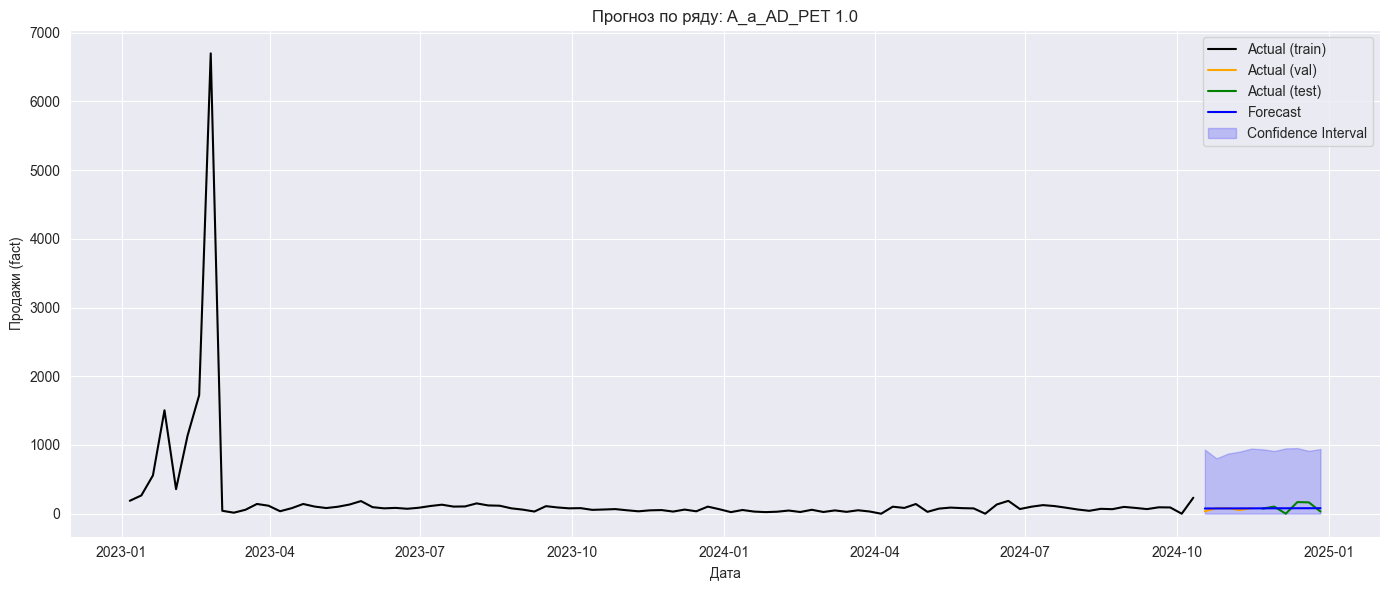

In [41]:
# 1. Обозначаем разметку для train / val / test
df_row['split'] = 'train'
df_row.loc[val_df.index, 'split'] = 'val'
df_row.loc[test_df.index, 'split'] = 'test'

# 2. Объединяем даты для прогноза: только val + test
future_dates = pd.concat([val_df[['ds']], test_df[['ds']]])

# 3. Генерируем прогноз
forecast_full = best_model.predict(future_dates)

# 4. Обрезаем отрицательные значения
forecast_full['yhat'] = forecast_full['yhat'].clip(lower=0)
forecast_full['yhat_lower'] = forecast_full['yhat_lower'].clip(lower=0)
forecast_full['yhat_upper'] = forecast_full['yhat_upper'].clip(lower=0)

# 5. Визуализация
plt.figure(figsize=(14, 6))

# Истинные значения (train, val, test)
for split, color in zip(['train', 'val', 'test'], ['black', 'orange', 'green']):
    plt.plot(df_row[df_row['split'] == split]['ds'],
             df_row[df_row['split'] == split]['y'],
             label=f'Actual ({split})', color=color)

# Прогноз (только на val + test)
plt.plot(forecast_full['ds'], forecast_full['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast_full['ds'],
                 forecast_full['yhat_lower'],
                 forecast_full['yhat_upper'],
                 color='blue', alpha=0.2, label='Confidence Interval')

plt.title(f'Прогноз по ряду: {target_row}')
plt.xlabel('Дата')
plt.ylabel('Продажи (fact)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Для всего датасета

In [43]:
def process_row_id(df, row_id, param_grid):
    try:
        # 1. Подготовка данных
        df_row = df[df['row_id'] == row_id].copy()
        df_row = df_row.rename(columns={"Week_End_Date": "ds", "fact": "y"})
        df_row = df_row.sort_values("ds").reset_index(drop=True)

        # 2. Разбиение
        n = len(df_row)
        train_size = int(n * 0.90)
        val_size = int(n * 0.05)
        train_df = df_row.iloc[:train_size]
        val_df = df_row.iloc[train_size:train_size + val_size]
        test_df = df_row.iloc[train_size + val_size:]

        # 3. Сетка параметров
        all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
        best_mae = float('inf')
        best_model = None
        best_params = None

        for params in all_params:
            model = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_mode=params['seasonality_mode'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                weekly_seasonality=True,
                yearly_seasonality=False
            )
            model.fit(train_df)

            # Прогноз на validation
            forecast_val = model.predict(val_df[['ds']])
            y_pred_val = forecast_val['yhat'].clip(lower=0)
            mae = mean_absolute_error(val_df['y'], y_pred_val)

            if mae < best_mae:
                best_mae = mae
                best_model = model
                best_params = params

        # 4. Прогноз на test
        forecast_test = best_model.predict(test_df[['ds']])
        y_pred_test = forecast_test['yhat'].clip(lower=0)

        # 5. Метрики на test
        y_true = test_df['y'].values
        mae = mean_absolute_error(y_true, y_pred_test)
        wape_val = wape(y_true, y_pred_test)
        smape_val = smape(y_true, y_pred_test)

        return {
            'row_id': row_id,
            'best_params': best_params,
            'mae': mae,
            'wape': wape_val,
            'smape': smape_val
        }

    except Exception as e:
        return {
            'row_id': row_id,
            'error': str(e)
        }

In [44]:
# Получаем список всех row_id
all_ids = df['row_id'].unique()

In [45]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [5.0, 10.0]
}

In [47]:
# Обработка с прогресс-баром
results = Parallel(n_jobs=-1)(delayed(process_row_id)(df, row_id, param_grid)
                              for row_id in tqdm(all_ids))

results_df = pd.DataFrame(results)


100%|██████████| 602/602 [06:04<00:00,  1.65it/s]


In [48]:
results_df

,row_id,best_params,mae,wape,smape
0,A_a_AC_TP 0.2,"{'changepoint_prior_scale': 0.05, 'seasonality...",2.445146,109.696998,82.450939
1,A_a_AC_TP 1.0,"{'changepoint_prior_scale': 0.05, 'seasonality...",87.358500,100.000000,200.000000
2,A_a_AD_PET 1.0,"{'changepoint_prior_scale': 0.05, 'seasonality...",55.231157,61.007781,76.882199
3,A_b_AA_PET 0.5,"{'changepoint_prior_scale': 0.5, 'seasonality_...",159.564864,264.870184,134.038321
4,A_b_AA_PET 1.0,"{'changepoint_prior_scale': 0.5, 'seasonality_...",82.016695,401.268935,146.227683
...,...,...,...,...,...
597,I_am_AH_PET 1.0,"{'changepoint_prior_scale': 0.5, 'seasonality_...",176.138271,98.056247,150.487487
598,I_am_AJ_PET 1.0,"{'changepoint_prior_scale': 0.5, 'seasonality_...",52.356184,59.339392,79.089507
599,I_an_AC_PET 0.3,"{'changepoint_prior_scale': 0.5, 'seasonality_...",8.205017,138.426790,162.050546
600,I_an_AC_TP 2.0,"{'changepoint_prior_scale': 0.05, 'seasonality...",186.092224,103.993606,182.230252


In [49]:
results_df[['mae', 'wape', 'smape']].describe()

,mae,wape,smape
count,602.000000,602.000000,602.000000
mean,176.540091,501.241079,112.112952
std,323.462085,6390.812563,53.159584
min,0.305020,11.631795,11.523502
25%,10.481543,64.532331,69.729630
50%,47.316290,92.303794,101.396159
75%,178.472721,117.383251,158.805536
max,3092.453184,149184.742565,200.000000


In [50]:
results_df['wape_cliped'] = results_df['wape'].clip(upper = 300)
results_df[['mae', 'wape', 'smape', 'wape_cliped']].describe()

,mae,wape,smape,wape_cliped
count,602.000000,602.000000,602.000000,602.000000
mean,176.540091,501.241079,112.112952,107.086981
std,323.462085,6390.812563,53.159584,68.713628
min,0.305020,11.631795,11.523502,11.631795
25%,10.481543,64.532331,69.729630,64.532331
50%,47.316290,92.303794,101.396159,92.303794
75%,178.472721,117.383251,158.805536,117.383251
max,3092.453184,149184.742565,200.000000,300.000000


In [51]:
target_ids = [
  'E_u_AD_PET 0.5',
  'I_am_AE_PET 0.45',
  'A_c_AJ_PET 0.5',
  'D_o_AC_TP 0.2',
  'I_am_AA_PET 0.5'
]

In [52]:
# Фильтруем и собираем метрики
metrics_summary = []

for row_id in target_ids:
    r = next((x for x in results if x['row_id'] == row_id), None)
    if r:
        metrics_summary.append({
            'row_id': row_id,
            'mae': round(r.get('mae', float('nan')), 2),
            'wape': round(r.get('wape', float('nan')), 2),
            'smape': round(r.get('smape', float('nan')), 2),
        })
    else:
        metrics_summary.append({
            'row_id': row_id,
            'mae': 'N/A',
            'wape': 'N/A',
            'smape': 'N/A',
        })

# Создаём DataFrame
metrics_df_subset = pd.DataFrame(metrics_summary)
metrics_df_subset

,row_id,mae,wape,smape
0,E_u_AD_PET 0.5,62.31,91.18,68.05
1,I_am_AE_PET 0.45,15.66,90.61,107.63
2,A_c_AJ_PET 0.5,67.64,100.00,200.00
3,D_o_AC_TP 0.2,47.48,59.54,62.09
4,I_am_AA_PET 0.5,10.54,83.05,142.38


In [53]:
def plot_forecast_for_row(df, row_id, param_grid):
    # 1. Подготовка данных
    df_row = df[df['row_id'] == row_id].copy()
    df_row = df_row.rename(columns={"Week_End_Date": "ds", "fact": "y"})
    df_row = df_row.sort_values("ds").reset_index(drop=True)

    # 2. Разбиение
    n = len(df_row)
    train_size = int(n * 0.90)
    val_size = int(n * 0.05)
    train_df = df_row.iloc[:train_size]
    val_df = df_row.iloc[train_size:train_size + val_size]
    test_df = df_row.iloc[train_size + val_size:]

    # 3. Подбор лучших параметров
    from itertools import product
    from prophet import Prophet
    from sklearn.metrics import mean_absolute_error

    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    best_mae = float('inf')
    best_model = None

    for params in all_params:
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            weekly_seasonality=True,
            yearly_seasonality=False
        )
        model.fit(train_df)
        forecast_val = model.predict(val_df[['ds']])
        y_pred_val = forecast_val['yhat'].clip(lower=0)
        mae = mean_absolute_error(val_df['y'], y_pred_val)
        if mae < best_mae:
            best_mae = mae
            best_model = model

    # 4. Прогноз на val + test
    future_dates = pd.concat([val_df[['ds']], test_df[['ds']]])
    forecast = best_model.predict(future_dates)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

    # 5. Разметка и график
    df_row['split'] = 'train'
    df_row.loc[val_df.index, 'split'] = 'val'
    df_row.loc[test_df.index, 'split'] = 'test'

    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 6))

    for split, color in zip(['train', 'val', 'test'], ['black', 'orange', 'green']):
        plt.plot(df_row[df_row['split'] == split]['ds'],
                 df_row[df_row['split'] == split]['y'],
                 label=f'Actual ({split})', color=color)

    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
    plt.fill_between(forecast['ds'],
                     forecast['yhat_lower'],
                     forecast['yhat_upper'],
                     color='blue', alpha=0.2, label='Confidence Interval')

    plt.title(f'Forecast: {row_id}')
    plt.xlabel('Дата')
    plt.ylabel('Продажи (fact)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1]

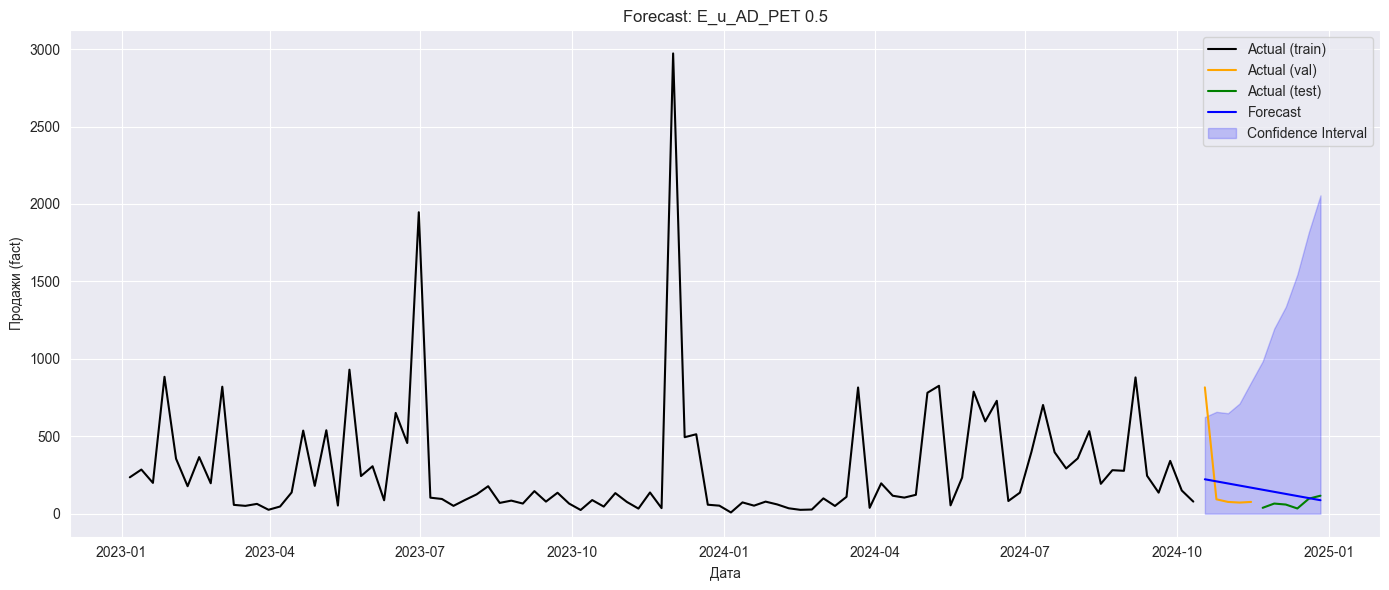

21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing
21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing
21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing
21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1]

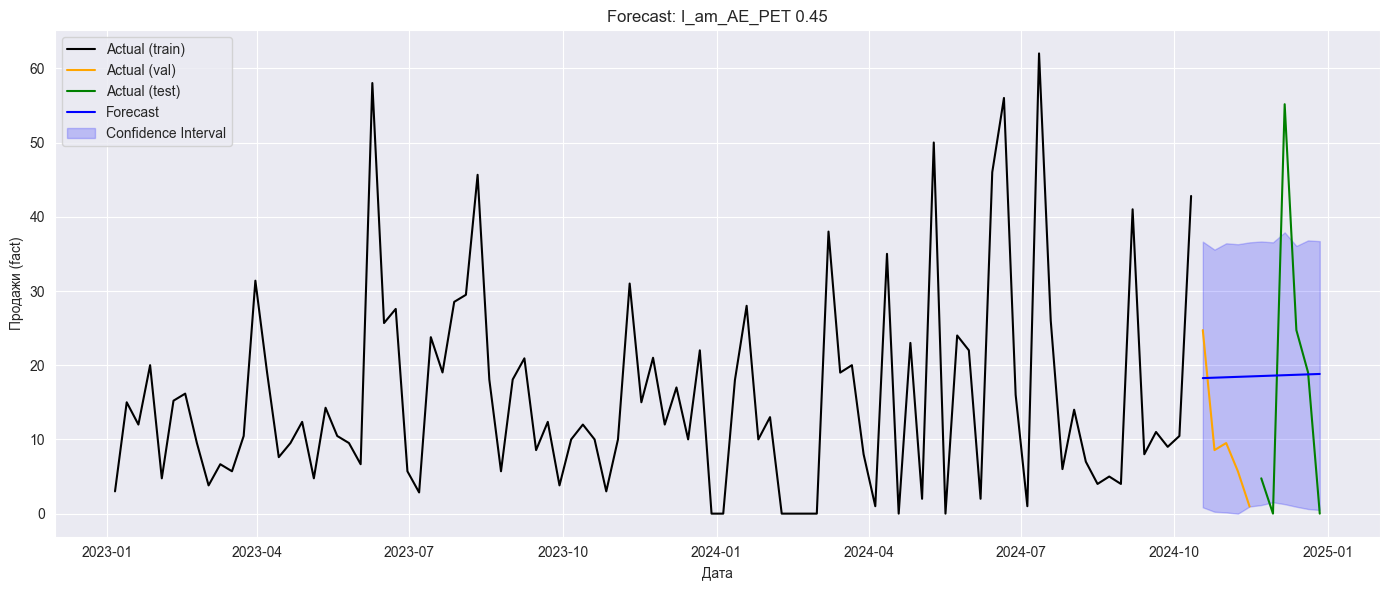

21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1]

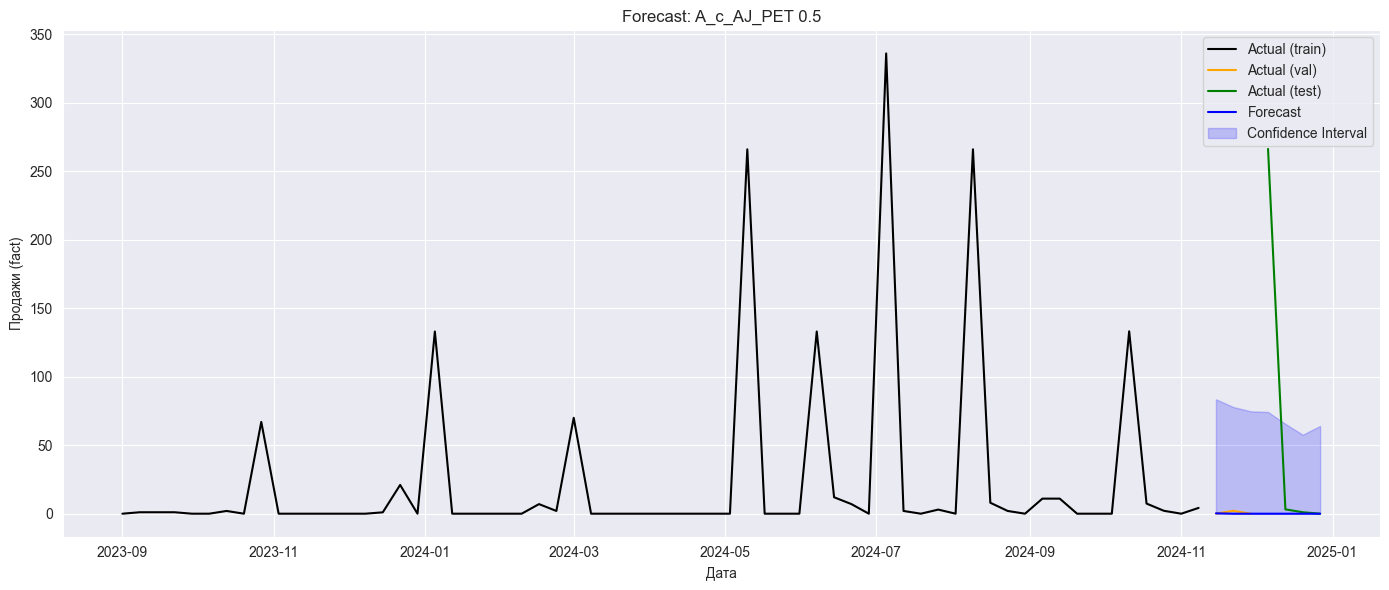

21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1]

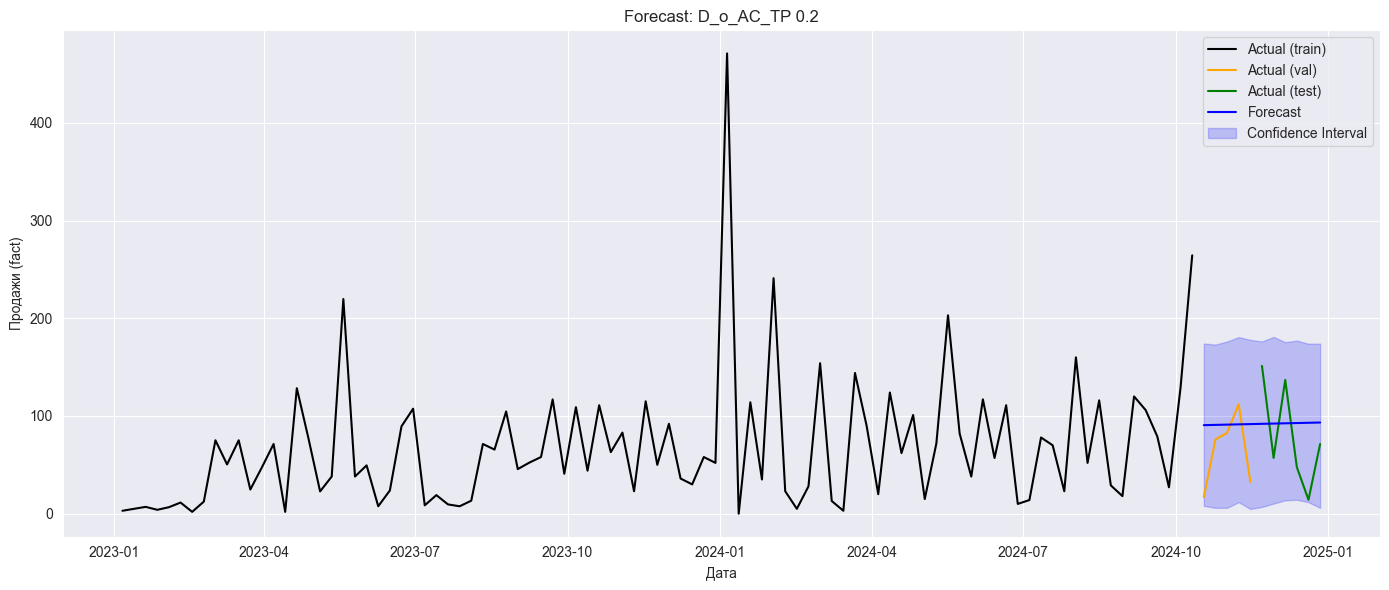

21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1]

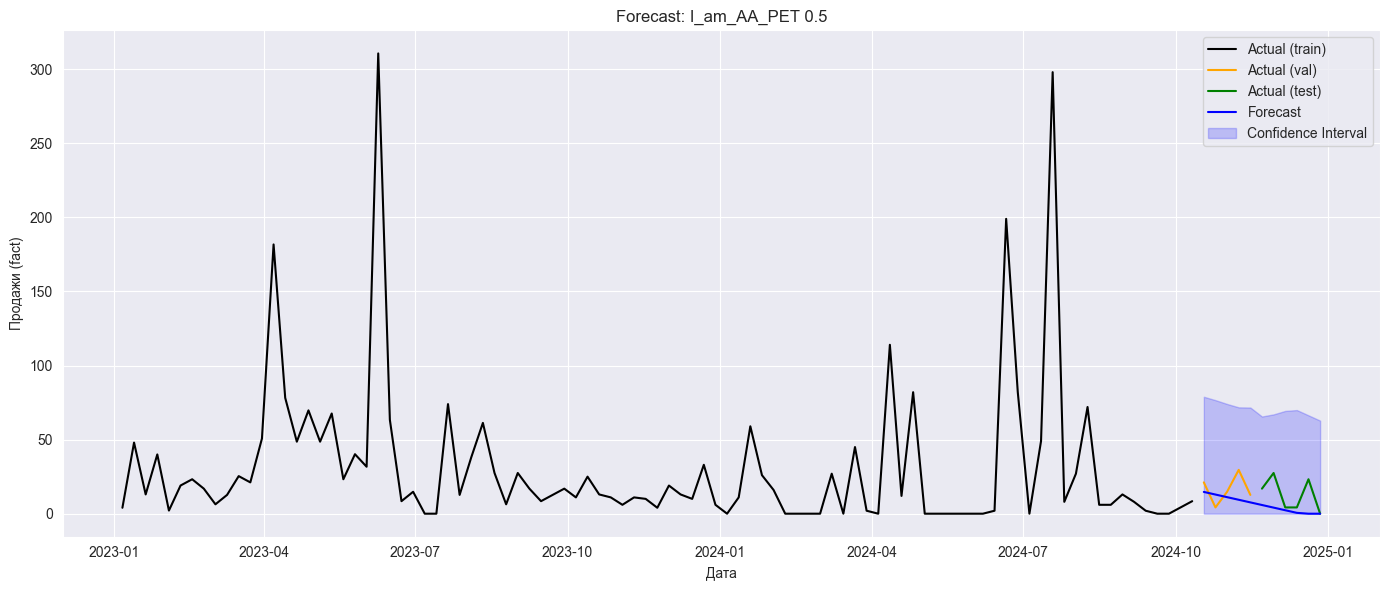

In [54]:
for row_id in target_ids:
    plot_forecast_for_row(df, row_id, param_grid)